# Electric Production Forecast by PyTorch LSTM and SARIMA models

This project aims to model the Electric Production IP index in US using data from 1985 to 2017 (UCI Dataset).<br>
The notebook is organized as follows:<br>
- PyTorch LSTM RNN :
    - Data preparation for LSTM training : scaling, reshaping
    - LSTM modeling
    - LSTM Prediction
    - LSTM Forecast
 <br>
- SARIMA:<br>
    - Data preparation for SARIMA: stationarity analysis, PACF, ACF
    - SARIMA modeling
    - SARIMA Prediction
    - SARIMA Forecast

# Prediction and Forecast comparison:

<img src="https://i.imgur.com/3x3yTR5.png">

**The results look indeed very similar both in terms of rmse and mape.**

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/time-series-datasets/daily-minimum-temperatures-in-me.csv
/kaggle/input/time-series-datasets/sales-of-shampoo-over-a-three-ye.csv
/kaggle/input/time-series-datasets/Electric_Production.csv
/kaggle/input/time-series-datasets/monthly-beer-production-in-austr.csv


## Custom Functions definition

In [2]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from math import sqrt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


In [4]:
df=pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv', index_col='DATE', parse_dates=True)

In [5]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [6]:
df.columns = ['value']

In [7]:
df.tail()

,value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


There are no missing values!

<AxesSubplot:xlabel='DATE'>

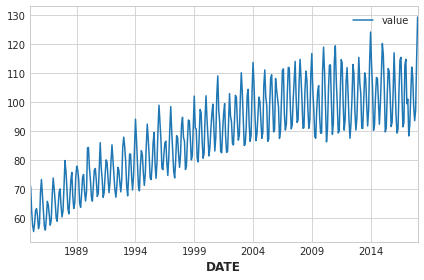

In [9]:
df.plot()

The data can be interpreted as a time series with a clear positive trend and seasonality.<br>
In the following, prediction models by LSTM RNN and SARIMAX will be developed to forecast the time series.

# PyTorch LSTM RNN 

The first thing we must do is to properly shape the input data. When modeling a time series by LSTM RNN, it is crucial to to properly shape the input data in a sliding windows format. In this application, the data is given as monthly data. So, for example, we can use a 12 steps prediction window. This means that we use 12 samples of data (data of an entire year) to predict the 13th sample.

In [10]:
prediction_window=12

In [11]:
n_input=12 #Use 12 months data to predict 13 th month data
n_features=1 # we are dealing with an univariate time series, so n_features should be set to 1. 
#In case of a multivariate time series, n_features should be set to a proper value higher than 1.

Then we create a copy named "train" of the original dataframe "df" which will be used in the following.

In [12]:
train = df.copy()

Since we will use a RNN, it is recommended to rescale the data.

In [13]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

Now we can formally create the train set. As stated before, the train set will have a "sliding window" shape. This means that we have to shape the data in such a way that the RNN will predict the 13th sample starting from the previous from 12 samples.

In [14]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [15]:
x, y = sliding_windows(scaled_train, prediction_window)

In [16]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.23201741 0.20727443 0.09630353 0.02910391 0.         0.03745865
 0.09859805 0.10707831 0.07112325 0.0135012  0.03624525 0.18085375]
Predict this value: 
 [0.24282188]


In [17]:
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

Then we convert the data to the tensor format required by PyTorch.

In [18]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# LSTM Modeling

In [19]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out,_) = self.lstm(x, (h0,c0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc2(self.relu(self.fc1(h_out)))
        
        return out

Then we set some parameters for the training:

In [20]:
EPOCHS = 2000
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [21]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMNet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [22]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# LSTM Training Loop

In [23]:
early_stopping_patience = 150
early_stopping_counter = 0

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    
    train_loss = criterion(output, y_train)
    
    train_loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)
        
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 #reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

Epoch 0: Validation loss decreased (inf --> 0.286754).  Saving model ...
	 Train_Loss: 0.2143 Val_Loss: 0.2868  BEST VAL Loss: 0.2868

Epoch 1: Validation loss decreased (0.286754 --> 0.181631).  Saving model ...
	 Train_Loss: 0.1469 Val_Loss: 0.1816  BEST VAL Loss: 0.1816

Epoch 2: Validation loss decreased (0.181631 --> 0.026999).  Saving model ...
	 Train_Loss: 0.0853 Val_Loss: 0.0270  BEST VAL Loss: 0.0270

Epoch 3: Validation loss decreased (0.026999 --> 0.022901).  Saving model ...
	 Train_Loss: 0.0362 Val_Loss: 0.0229  BEST VAL Loss: 0.0229

Epoch 4: Validation loss did not decrease
	 Train_Loss: 0.0405 Val_Loss: 0.0687  BEST VAL Loss: 0.0229

Epoch 5: Validation loss did not decrease
	 Train_Loss: 0.0355 Val_Loss: 0.0853  BEST VAL Loss: 0.0229

Epoch 6: Validation loss did not decrease
	 Train_Loss: 0.0406 Val_Loss: 0.0723  BEST VAL Loss: 0.0229

Epoch 7: Validation loss did not decrease
	 Train_Loss: 0.0363 Val_Loss: 0.0481  BEST VAL Loss: 0.0229

Epoch 8: Validation loss did 

# LSTM Prediction

Now, we will check the values predicted by the LSTM RNN on the validation data

In [24]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [25]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [26]:
df_pred=train.iloc[-24:]
df_pred['prediction']=y_pred

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


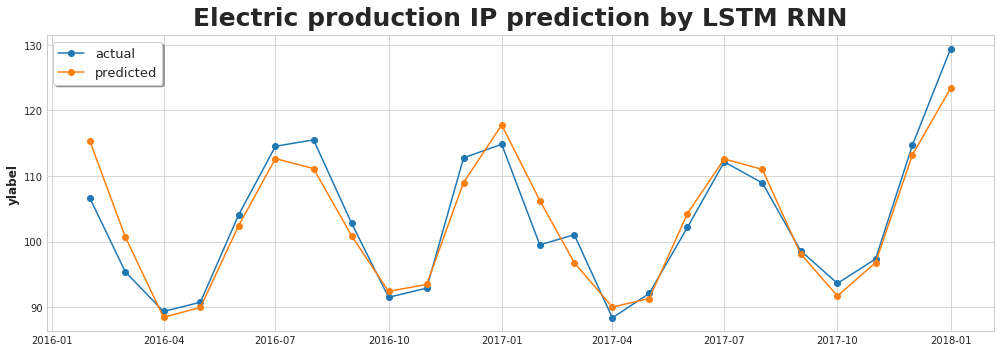

In [27]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["value"], label="actual", marker="o")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted", marker="o")
plt.title("Electric production IP prediction by LSTM RNN", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [28]:
mape_lstm = mape(df_pred["value"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 2.46 %


In [29]:
rmse_lstm = mean_squared_error(df_pred["value"], df_pred["prediction"], squared=False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

RMSE OF LSTM MODEL : 3.40


# LSTM Forecasting

In [30]:
test_predictions = []

first_eval_batch = Variable(torch.Tensor(scaled_train[-n_input:])) # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(scaled_train[-n_input:])):
    #get the prediction value for the first batch
    current_pred = model(current_batch)
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = torch.cat((current_batch[:,1:,:],current_pred.reshape(1,1,1)),1)

In [31]:
forec_vals = [val.flatten().item() for val in test_predictions]
forec_vals = np.array(forec_vals).reshape(-1,1)
forec_vals = scaler.inverse_transform(forec_vals)

In [32]:
date_offset=12
forecast_dates =  (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [33]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['prediction'] = forec_vals
df_forecast.head(12)

,prediction
date,
2018-02-01,113.265227
2018-03-01,101.401983
2018-04-01,91.312685
2018-05-01,93.187344
2018-06-01,103.304395
2018-07-01,111.755586
2018-08-01,111.690184
2018-09-01,99.456249
2018-10-01,92.640160


In [34]:
df_full=df_pred.append(df_forecast)

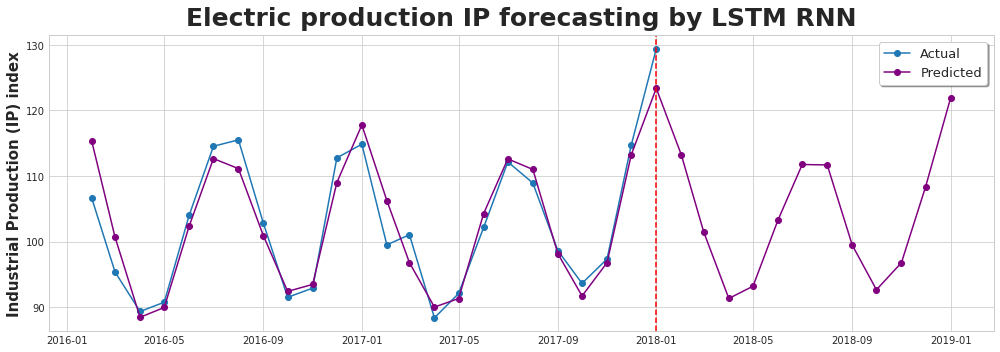

In [35]:
plt.figure(figsize=(14,5))
plt.plot(df_full.index,df_full["value"], label="Actual", marker="o")
plt.plot(df_full.index,df_full["prediction"], label="Predicted", marker="o", color="purple")
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.title("Electric production IP forecasting by LSTM RNN", fontsize=25)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

# SARIMA modeling

In the following,the time series will be modeled by as a SARIMA model.

We can use some useful tools such as 'seasonal decompose' to better visualize the time series.

<Figure size 432x288 with 0 Axes>

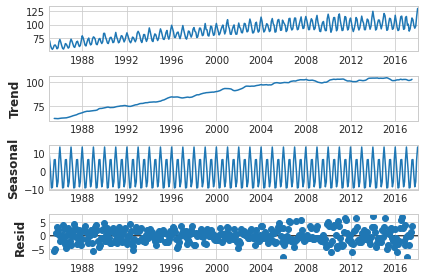

In [36]:
result = seasonal_decompose(df)

fig = plt.figure()  
fig = result.plot()

We can also check the stationarity of the time serie by performing the Augmented Dickey Fuller (ADF) test.

In [37]:
result=adfuller(df.value.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-2.2569903500472366
p-value:0.18621469116587053


The p-value is higher than 0.05. This means that the time serie is non stationary with a confidence of 95%. We check if with a one step differentiation, the time serie become stationary (in terms of a trendless time series).

In [38]:
result=adfuller(df.value.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-7.104890882267309
p-value:4.0777865655394705e-10


Now the series looks stationary with a 1-order difference

## ACF and PACF

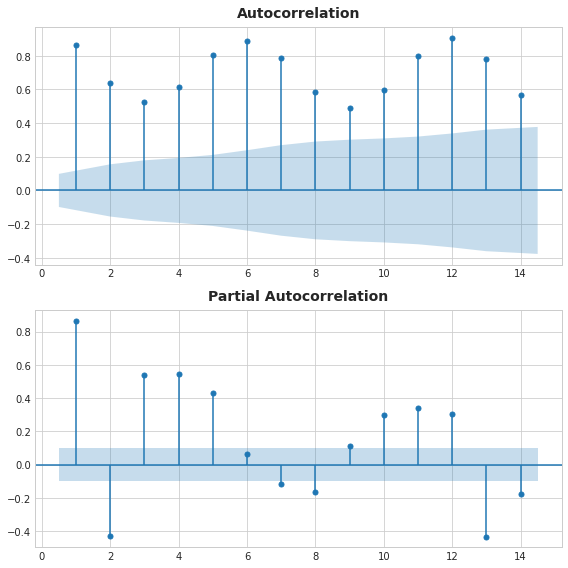

In [39]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df,lags=14, zero=False, ax=ax1)
plot_pacf(df,lags=14, zero=False, ax=ax2)
plt.show()

The series looks indeed non stationary

## Auto ARIMA

In [40]:
!pip install pmdarima
import pmdarima as pm

     |████████████████████████████████| 1.4 MB 5.0 MB/s eta 0:00:01


In [41]:
results=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1912.925, Time=0.86 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2404.500, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1998.731, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2057.803, Time=0.33 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2000.250, Time=0.82 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1880.044, Time=1.26 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.96 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=3.22 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=1925.181, Time=0.87 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=1942.791, Time=0.69 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=1881.313, Time=1.97 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=1880.682, Time=1.69 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=1955.485, T

In [42]:
model=SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 2, 6))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62107D+00    |proj g|=  1.35732D-01


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.31439D+00    |proj g|=  2.99144D-02

At iterate   10    f=  2.28953D+00    |proj g|=  1.30022D-02

At iterate   15    f=  2.26953D+00    |proj g|=  3.67458D-02

At iterate   20    f=  2.26706D+00    |proj g|=  4.60416D-03

At iterate   25    f=  2.26588D+00    |proj g|=  1.02781D-02

At iterate   30    f=  2.26473D+00    |proj g|=  1.20999D-03

At iterate   35    f=  2.26471D+00    |proj g|=  5.25788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     46      1     0     0   3.090D-05   2.265D+00
  F =   2.2647070235339561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                  397
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                -899.089
Date:                           Wed, 19 Jan 2022   AIC                           1814.177
Time:                                   09:01:44   BIC                           1845.907
Sample:                               01-01-1985   HQIC                          1826.755
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0873      0.350     -0.249      0.803      -0.773       0.599
ar.L2          0.2828      0.214      1.321      0.187      -0.137       0.702
ma.L1         -0.2982      0.337     -0.884      0.377      -0.959       0.363
ma.L2         -0.6397      0.329     -1.944      0.052      -1.285       0.005
ar.S.L6       -0.9976      0.003   -380.207      0.000      -1.003      -0.992
ma.S.L6        0.1145      0.040      2.832      0.005       0.035       0.194
ma.S.L12      -0.7764      0.037    -20.853      0.000      -0.849      -0.703
sigma2         5.5549      0.307     18.092      0.000       4.953       6.157
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


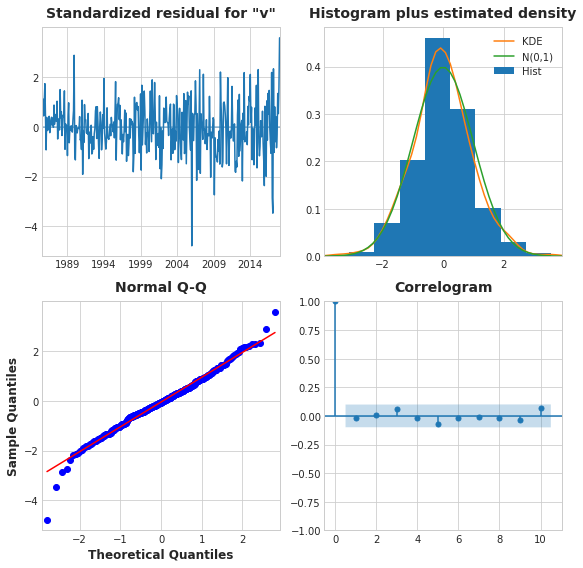

In [44]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

All the 4 plots indicates a good fit of the SARIMA model on the given time serie.

# SARIMA Prediction

Now we will create a vector that will host the predictions

In [45]:
prediction = results.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")

Moreover, we also get the confidence intervals from the sarima prediction

In [46]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

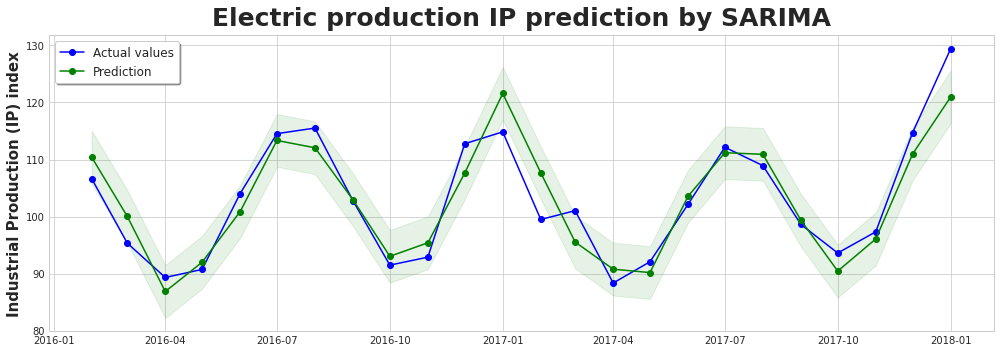

In [47]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by SARIMA", fontsize=25)

plt.plot(df[-24:].index,df[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [48]:
mape_sarima = mape(df.iloc[-24:,0],mean_prediction)
print(f"MAPE OF LSTM MODEL : {mape_sarima:.2f} %")

MAPE OF LSTM MODEL : 3.02 %


In [49]:
rmse_sarima = sqrt(mean_squared_error(df[-24:].values,mean_prediction.values))
print(f"RMSE OF LSTM MODEL : {rmse_sarima:.2f}")

RMSE OF LSTM MODEL : 3.87


# SARIMA Forecast

In [50]:
# Make ARIMA forecast of next 10 values
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")

In [51]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

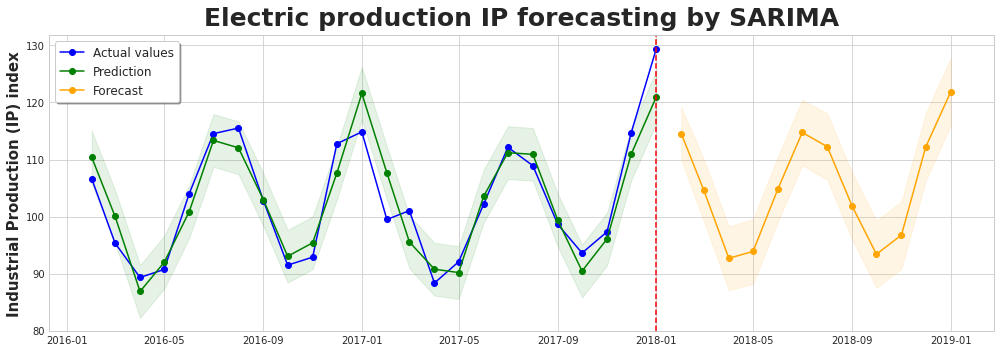

In [52]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by SARIMA", fontsize=25)

plt.plot(df[-24:].index,df[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-24:].index,mean_forecast[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-24:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [53]:
df_sarimax = mean_prediction.append(mean_forecast)

# Results Sumamry

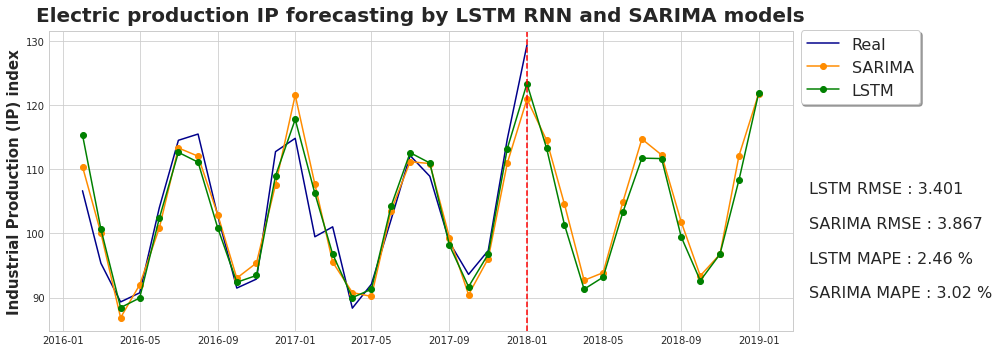

In [54]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by LSTM RNN and SARIMA models", fontsize=20)
plt.plot(df[-24:].index,df[-24:].values, color='darkblue', label='Real')
plt.plot(df_sarimax.index, df_sarimax.values, color='darkorange', label='SARIMA', marker='o')
plt.plot(df_full.index, df_full['prediction'].values, color='green',label='LSTM', marker='o')
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(bbox_to_anchor=(1, 1.03),fontsize=16,fancybox=True, shadow=True, frameon=True)
text = 'LSTM RMSE : {:.3f}\n\nSARIMA RMSE : {:.3f}\n\nLSTM MAPE : {:.2f} %\n\nSARIMA MAPE : {:.2f} %'.format(rmse_lstm,rmse_sarima,mape_lstm,mape_sarima)
plt.text(mean_forecast.index[-1] + pd.DateOffset(days=80),90,text, fontsize=16)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

**We can see that SARIMA and LSTM obtained very similar results visually and in both terms of MAPE and RMSE.**

**Thanks for reading my notebook ! Write a comment if you have any questions or if you want me to check out your works :)**